In [1]:
import torchvision
from torchvision import datasets, models, transforms
import time
import os
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

In [2]:
transforms = transforms.Compose([
transforms.Resize(256),
transforms.CenterCrop(224),
transforms.ToTensor(),
transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])
train_set = datasets.ImageFolder("data/train",transforms)
val_set = datasets.ImageFolder("data/val",transforms)
model = models.resnet34(pretrained=True)

In [3]:
data_dir = "./data"
model_name = "resnet"
num_classes = 2
batch_size = 8
num_epochs = 20
feature_extract = False

In [4]:
train_loss =[]
train_acc = []
val_loss = []
val_acc = []

def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Epochs divided into training and validation set
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Training mode
            else:
                model.eval()   # Evaluation mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)


                    #Backward and optimize iff it is in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'train':
              train_loss.append(epoch_loss)
              train_acc.append(epoch_acc)
            else:
              val_loss.append(epoch_loss)
              val_acc.append(epoch_acc)

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Loading model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

### Initialization for 2 classes

In [5]:
def initialize_model(num_classes):
    input_size = 0
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    input_size = 224
    
    return model, input_size

In [6]:
model, input_size = initialize_model(num_classes)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
print("Initializing Datasets and Dataloaders...")


# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), transforms) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


In [8]:
dataloaders_dict

{'train': <torch.utils.data.dataloader.DataLoader at 0x11e6f2e10>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x11db41c10>}

In [9]:
dataloaders_dict['train']

In [10]:
len(dataloaders_dict['train'].dataset)

60

### Train the model

In [11]:
model = model.to(device)

# Observe that all parameters are being optimized
params_to_update = model.parameters()
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model, hist = train_model(model, dataloaders_dict, criterion, optimizer_ft, num_epochs)

Epoch 0/19
----------
train Loss: 0.5928 Acc: 0.7167
val Loss: 0.2595 Acc: 0.9583

Epoch 1/19
----------
train Loss: 0.3001 Acc: 0.8333
val Loss: 0.0789 Acc: 0.9583

Epoch 2/19
----------
train Loss: 0.0905 Acc: 1.0000
val Loss: 0.0203 Acc: 1.0000

Epoch 3/19
----------
train Loss: 0.0983 Acc: 0.9667
val Loss: 0.0144 Acc: 1.0000

Epoch 4/19
----------
train Loss: 0.0145 Acc: 1.0000
val Loss: 0.0144 Acc: 1.0000

Epoch 5/19
----------
train Loss: 0.0542 Acc: 1.0000
val Loss: 0.0109 Acc: 1.0000

Epoch 6/19
----------
train Loss: 0.0464 Acc: 0.9833
val Loss: 0.0135 Acc: 1.0000

Epoch 7/19
----------
train Loss: 0.0640 Acc: 1.0000
val Loss: 0.0142 Acc: 1.0000

Epoch 8/19
----------
train Loss: 0.1037 Acc: 0.9500
val Loss: 0.0082 Acc: 1.0000

Epoch 9/19
----------
train Loss: 0.0211 Acc: 1.0000
val Loss: 0.0039 Acc: 1.0000

Epoch 10/19
----------
train Loss: 0.0134 Acc: 1.0000
val Loss: 0.0031 Acc: 1.0000

Epoch 11/19
----------
train Loss: 0.0505 Acc: 0.9833
val Loss: 0.0035 Acc: 1.0000

Ep

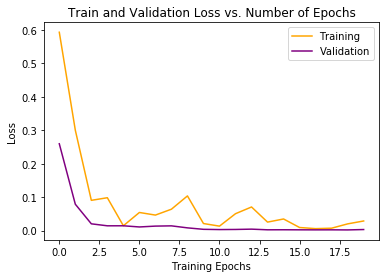

In [13]:
import matplotlib.pyplot as plt
plt.title("Train and Validation Loss vs. Number of Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Loss")

plt.plot(np.arange(num_epochs),train_loss,'orange',label="Training")
plt.plot(np.arange(num_epochs),val_loss,'purple',label="Validation")
plt.legend()
plt.show()

In [ ]:
Reference: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html